In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import torch
from models.classifier import Classifier, FixedBatchNorm
from models.decoder import Decoder
from models.encoder import Encoder
from models.pipeline import Pipeline
from models.resnet import resnet50, resnet101, resnet152
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
from skimage import io, transform
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (50,5)

In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
backbone = resnet50(pretrained=True, strides=(2, 2, 2, 1))
encoder_model = Encoder(backbone=backbone)
classifier_model = Classifier(
    in_channels=2048, num_classes=20
)
decoder_model = Decoder(
    in_channels=2048,
    out_ch=21,
    input_shape=(512, 512),
    dilate_version=1,
)
model = Pipeline(
    encoder_model=encoder_model,
    classifier_model=classifier_model,
    decoder_model=decoder_model,
)

In [5]:
from dataset_loaders import my_collate
from torch.utils.data import DataLoader
from voc12 import dataloader
voc12_root = "../../vision/data/raw/VOCdevkit/VOC2012"
train_path = "../voc12/train_aug.txt"

def data_loaders():
    dataset = dataloader.VOC12ClassificationDatasetMSF(
        train_path, voc12_root=voc12_root, scales=[1, 0.5, 1.5, 2.0]
    )

    loader = DataLoader(
        dataset,
        drop_last=False,
        num_workers=0,
        persistent_workers=False,
        collate_fn=my_collate,
    )

    return loader
loader = data_loaders()

In [6]:
item = next(iter(loader))
len(item['img']), item['img'][0].shape, item['img'][0][0][0].shape

(4, torch.Size([1, 2, 3, 281, 500]), torch.Size([3, 281, 500]))

In [7]:
model.load_state_dict(torch.load('../results/pipeline/resnet50v2/train/weights/seg-model-224.pt'), strict=True)

<All keys matched successfully>

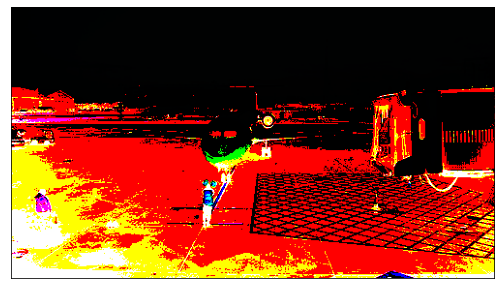

In [8]:
image_1 = item['img'][0][0]
show(image_1[0].type(torch.uint8))

In [9]:
label

NameError: name 'label' is not defined

In [ ]:
cams = [model.forward_cam(i[0]) for i in item['img']]
cams[0].shape, len(cams)

In [ ]:
cam.shape

In [ ]:
item['size']

In [ ]:
size = item['size']

In [ ]:
valid_cat = torch.nonzero(item['label'], as_tuple=False)[:, 0]
strided_cam = [
    torch.nn.functional.interpolate(
        torch.unsqueeze(o, 1), size, mode="bilinear", align_corners=False
    )
    for o in cams
]
strided_cam = torch.sum(torch.stack(strided_cam, 0), 0)[
    :, 0, : size[0], : size[1]
]

strided_cam = strided_cam[valid_cat]
strided_cam /= torch.nn.functional.adaptive_max_pool2d(strided_cam, (1, 1)) + 1e-5

strided_cam = np.pad(
    strided_cam,
    ((1, 0), (0, 0), (0, 0)),
    mode="constant",
    constant_values=0.15,
)
keys = np.pad(valid_cat + 1, (1, 0), mode="constant")
cls_labels = np.argmax(strided_cam, axis=0)
cls_labels = keys[cls_labels]
show(torch.from_numpy(cls_labels).type(torch.uint8))

In [ ]:
t = transforms.FiveCrop((256, 256))

In [ ]:
images = t(image)
image.shape, images[0].shape

In [ ]:
concat_images = torch.concat([images[0].unsqueeze(0), images[1].unsqueeze(0), images[2].unsqueeze(0), images[3].unsqueeze(0)], axis=0)

In [ ]:
concat_images.shape

In [ ]:
cams = net.forward_cam(concat_images.type(torch.FloatTensor))
cams.shape, concat_images.shape

In [ ]:
for i in range(concat_images.shape[0]):
    show([concat_images[i]])

In [ ]:
show([image])

In [ ]:
null_img = torch.zeros(list(image.shape))

In [ ]:
image_width = image.shape[1]
image_height = image.shape[2]

In [ ]:
image_width, image_height

In [ ]:
null_img[:, 0:256, 0:256] = images[0]

In [ ]:
null_img[:, 0:256, image_height -256:] = images[1]

In [ ]:
null_img[:, image_width-256:, 0:256] = images[2]

In [ ]:
null_img[:, image_width-256:, image_height -256:] = images[3]

In [ ]:
null_img = null_img.type(torch.uint8)

In [ ]:
show([null_img])

In [ ]:
null_img.shape, image.shape

In [ ]:
null_img.dtype, image.dtype

In [ ]:
(null_img == image).all()

In [ ]:
for cam in cams:
    print(cam.shape)
    valid_cat = torch.nonzero(sample['cls_label'], as_tuple=False)[:, 0]
    cam = torch.nn.functional.interpolate(
        cam.unsqueeze(0), (256, 256), mode="bilinear", align_corners=False
    )[0]
    strided_cam = cam[valid_cat]
    strided_cam /= torch.nn.functional.adaptive_max_pool2d(strided_cam, (1, 1)) + 1e-5

    strided_cams = np.pad(
        strided_cam,
        ((1, 0), (0, 0), (0, 0)),
        mode="constant",
        constant_values=0.3,
    )
    keys = np.pad(valid_cat + 1, (1, 0), mode="constant")
    cls_labels = np.argmax(strided_cams, axis=0)
    cls_labels = keys[cls_labels]
    show(torch.from_numpy(cls_labels).type(torch.uint8))

In [ ]:
show([cams[0][0], cams[1][0], cams[2][0], cams[3][0]])

In [ ]:
for i in range(concat_images.shape[0]):
    show([concat_images[i]])